In [1]:
import pandas as pd

In [2]:
data = pd.read_excel("Source Data 4 The source data for Figure 4 in manuscript.xlsx")

In [94]:
features = data[data.columns[:18]]

In [95]:
target = data[data.columns[18]]

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

In [90]:
clf = RandomForestClassifier(n_estimators=20, random_state=42)

In [91]:
scores = cross_val_score(clf, features, target, cv=5)

In [92]:
print('Mean CV score:', np.mean(scores))

Mean CV score: 0.3694376046488722


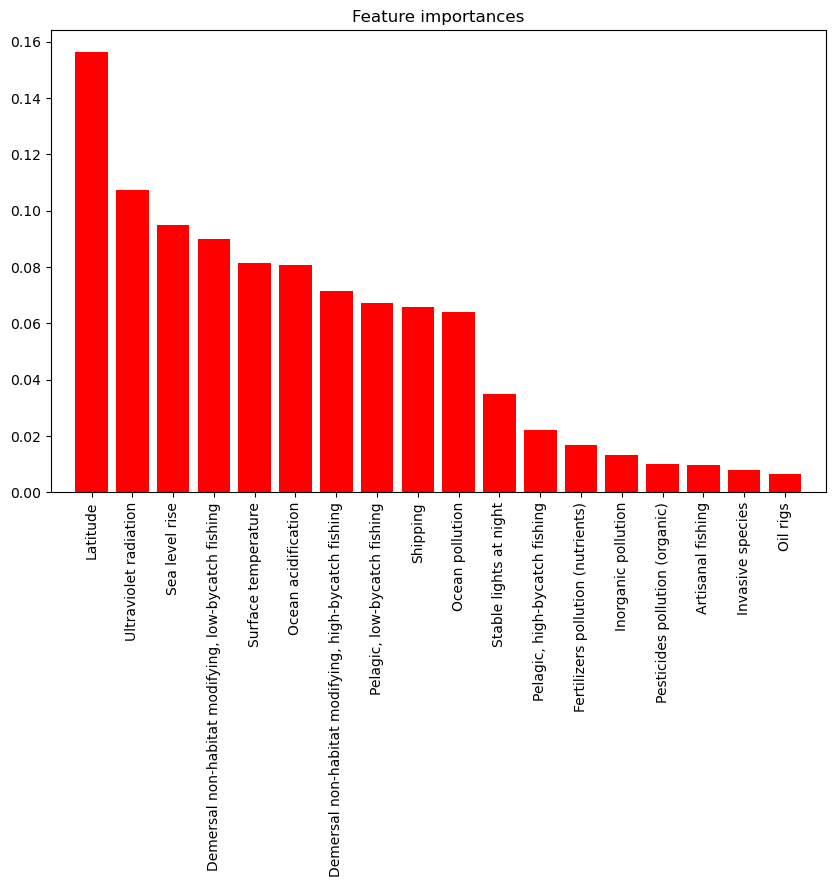

In [96]:
import matplotlib.pyplot as plt
clf = RandomForestClassifier(n_estimators=20, random_state=42)
clf.fit(features, target)

# Get feature importances
importances = clf.feature_importances_

# Get the feature names
features_names = features.columns

# Sort the features by importance
indices = np.argsort(importances)[::-1]
features_names = [features_names[i] for i in indices]
importances = [importances[i] for i in indices]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(features.shape[1]), importances, color="r", align="center")
plt.xticks(range(features.shape[1]), features_names, rotation='vertical')
plt.xlim([-1, features.shape[1]])
plt.show()


In [110]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
import numpy as np

clf = RandomForestClassifier(n_estimators=20, random_state=42)

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5)

# Initialize the scores
scores_ovr = []
scores_ovo = []

X = features.values
y = target.values

lb = LabelBinarizer()
lb.fit(y)

# Perform cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the model
    clf.fit(X_train, y_train)

    # Predict the probabilities of each class
    y_score = clf.predict_proba(X_test)

    # Binarize the output
    y_test_bin = lb.transform(y_test)

    # Compute and append the scores
    try:
        scores_ovr.append(roc_auc_score(y_test_bin, y_score, multi_class='ovr', average='macro'))
    except ValueError:
        pass
    try:
        scores_ovo.append(roc_auc_score(y_test_bin, y_score, multi_class='ovo', average='macro'))
    except ValueError:
        pass

# Compute and print the average scores
print('Average One-vs-Rest AUC-ROC: ', np.mean(scores_ovr))
print('Average One-vs-One AUC-ROC: ', np.mean(scores_ovo))


Average One-vs-Rest AUC-ROC:  0.6468027323434865
Average One-vs-One AUC-ROC:  0.6468027323434865
